#                                                   Метелица Кирилл Вариант 7

# Отчёт по лабораторной работе по домохозяйствам

## В данном отчёте представлены основные выводы из проделанной работе о домохозяйствах

# Производим импорт необходимых библиотек и считывание из них данных

In [49]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
from scipy import stats

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

DATA_PATH = './data/'

df = pd.read_csv(DATA_PATH + 'df.csv', index_col="Unnamed: 0")
weighted_df = pd.read_csv(DATA_PATH + 'weighted_df.csv', index_col="Unnamed: 0")

print("df shape:", df.shape)
print("weighted df shape:", weighted_df.shape)

df shape: (2000, 74)
weighted df shape: (701174, 74)


# 1. Предварительный анализ данных (EDA)

Признаки height, weight, bmi имеют нормальное распределение.

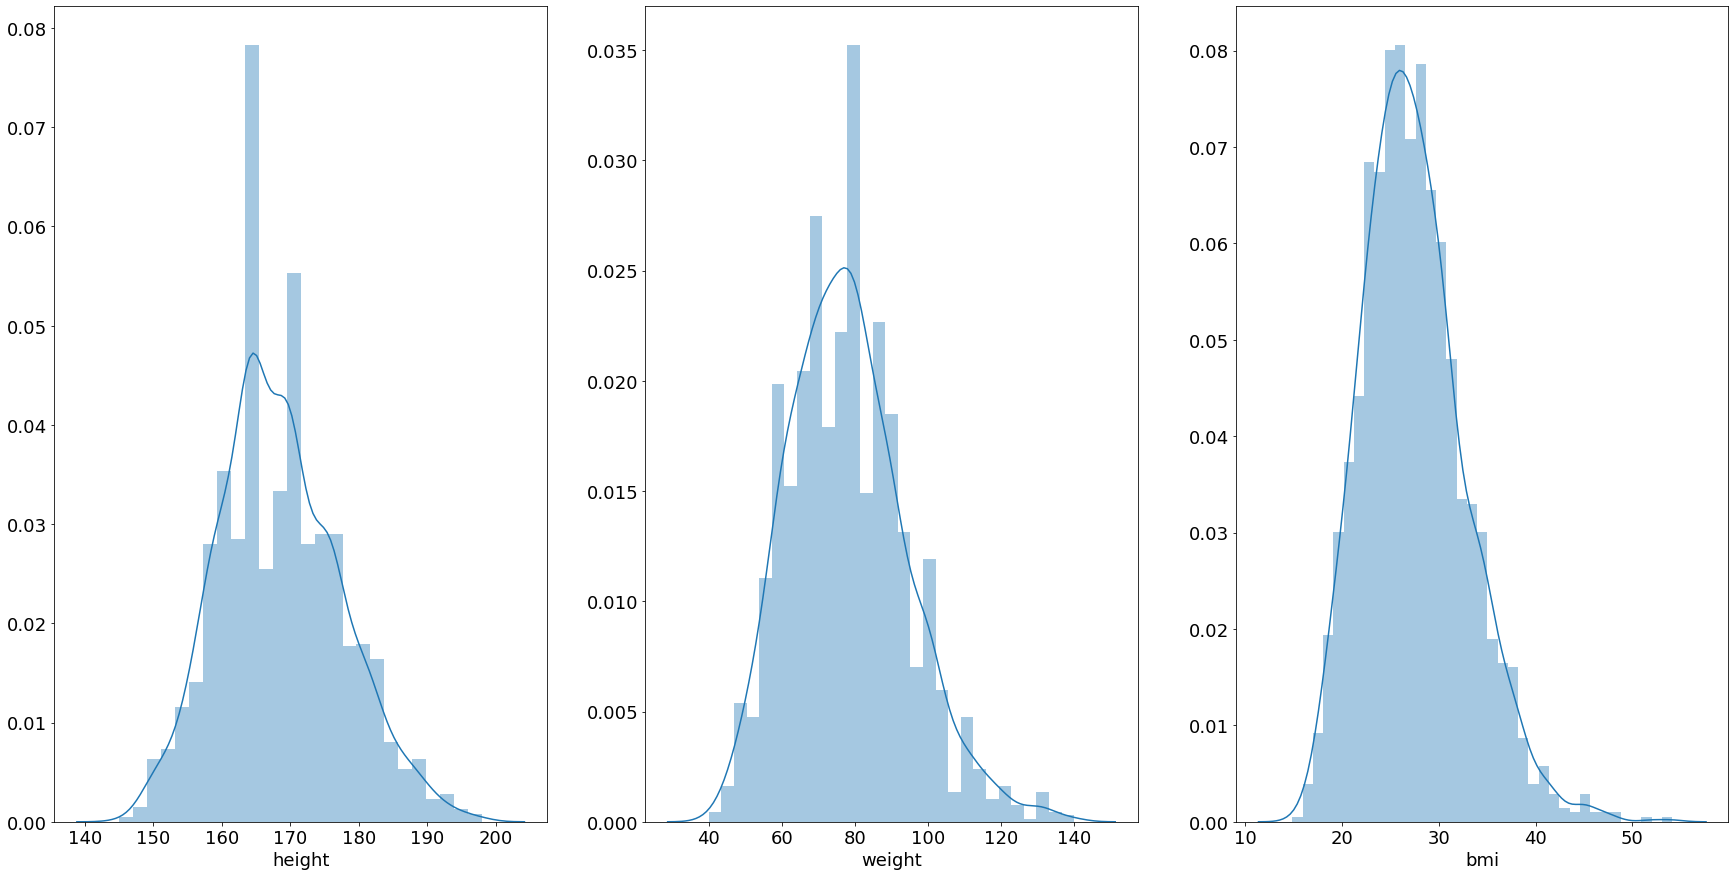

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(30, 15))

sns.distplot(df["height"], ax=axes[0])
sns.distplot(df["weight"], ax=axes[1])
sns.distplot(df["bmi"], ax=axes[2])

🔘 Женщин в датасете больше, чем мужчин: 1200 v 800

🔘 Регионы представлены примерно одинаково. Меньше всего - в Гродненской области (12.15%), больше всего - в Гомельской (16.30%). В Минске живет 2 млн человек (больше 20% населения страны), а в датасете его 13.75%. Хотя на взвешенной выборке ситуация меняется и Минск в ней представлен больше всего

🔘 По типам домохозяйств доминируют "2 и более взрослых с детьми" и "домохозяйство без детей", меньше всего семей с одним родителем

🔘 Самые распространённые домохозяйства - из двух (для невзвешенной выборки) и двух-трёх человек (для взвешенной выборки)

🔘 Самый популярный уровень образования - средне-специальное, меньше всего по уровню образования людей без него вовсе

🔘 Большинство оценивает своё здоровье как нормальное (не очень хорошее, не очень плохое). Людей, считающий, что у них хорошее здоровье в 2 раза больше, чем считающих, что плохое

Взвешенная выборка:


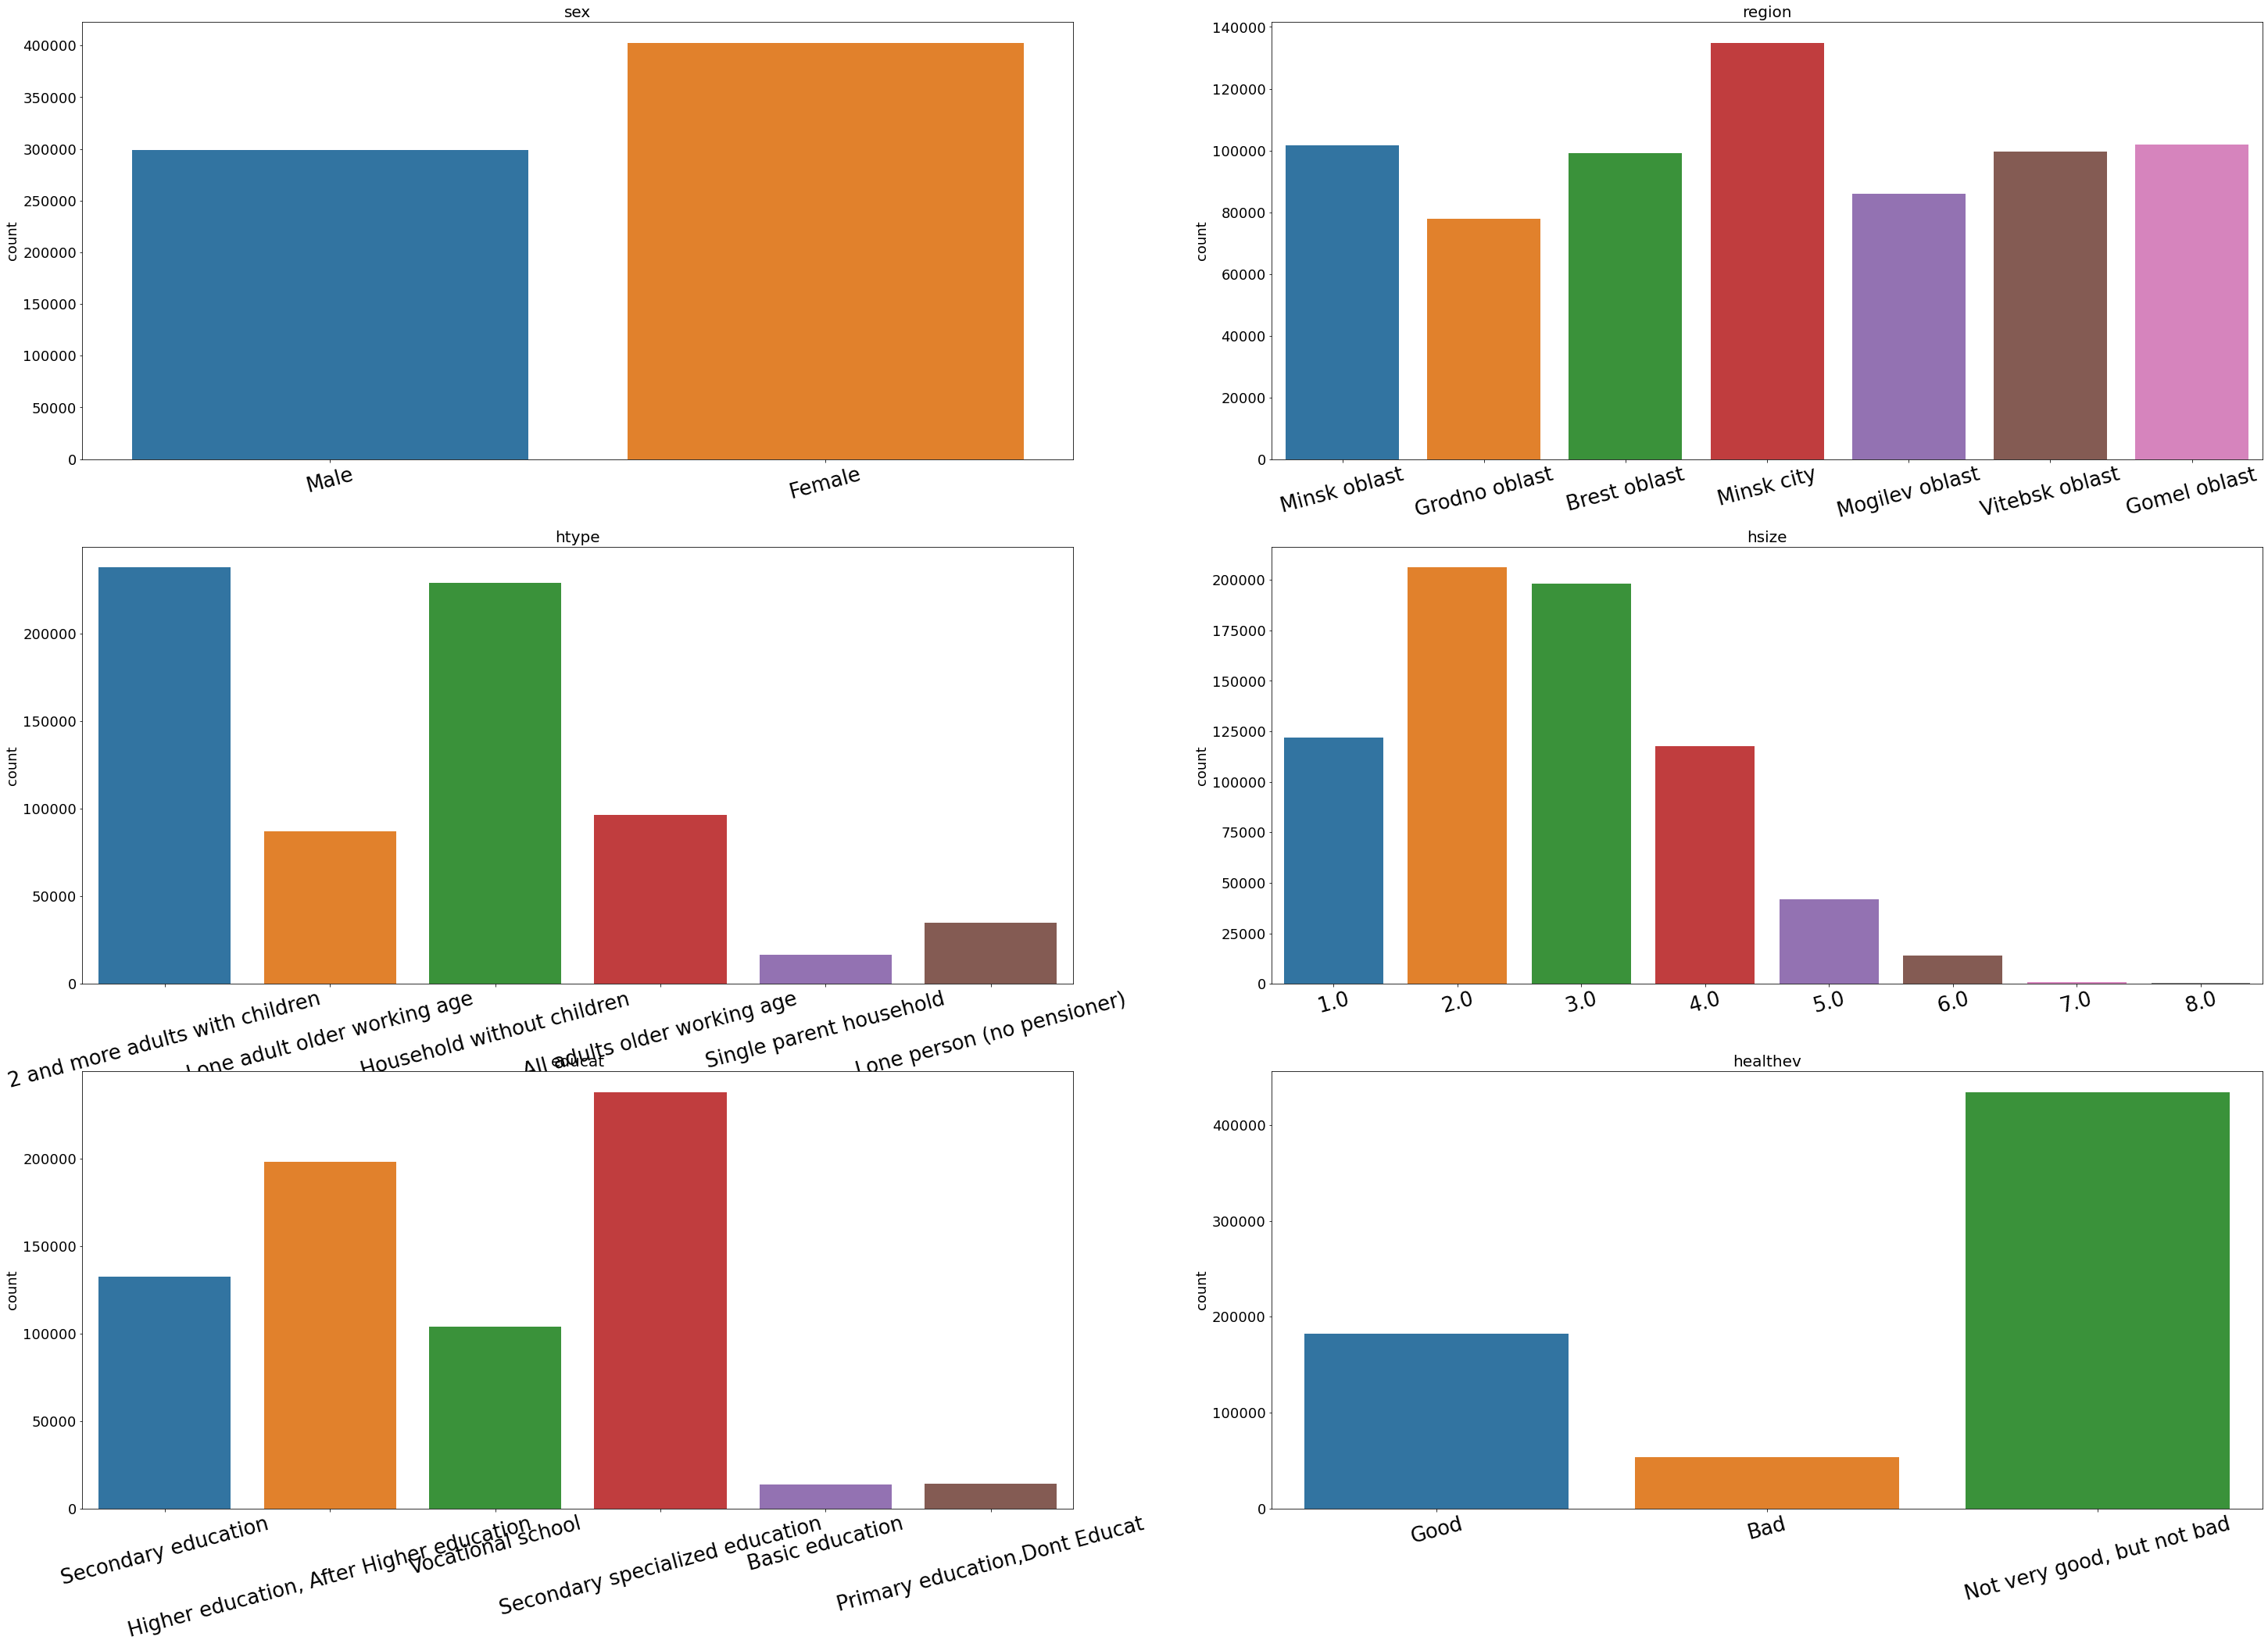

In [33]:
cols_to_plot = ["sex", "region", "htype", "hsize", "educat", "healthev"]
fig, axes = plt.subplots(3, 2, figsize=(50, 35))
axes = axes.reshape(-1)
for i in range(len(cols_to_plot)):
    col = cols_to_plot[i]
    sns.countplot(weighted_df[~weighted_df[col].isna()][col], ax=axes[i]).set_title(col, fontsize=20)
    plt.setp(axes[i].get_xticklabels(), rotation=15, fontsize='x-large')
    axes[i].set_xlabel(None)
    
print("Взвешенная выборка:")

Рассмотрев распределения зарплат (ppinc_1) и сбережений (savings): почти все зарплаты находятся в промежутке от 0 до 1500 рублей, в среднем люди "живут в ноль": не откладывают и не уходят в минусы, у большинства не получается откладывать больше 500 рублей. Треть страны живёт "в минус"

Text(0.5, 0, 'Взвешенная savings')

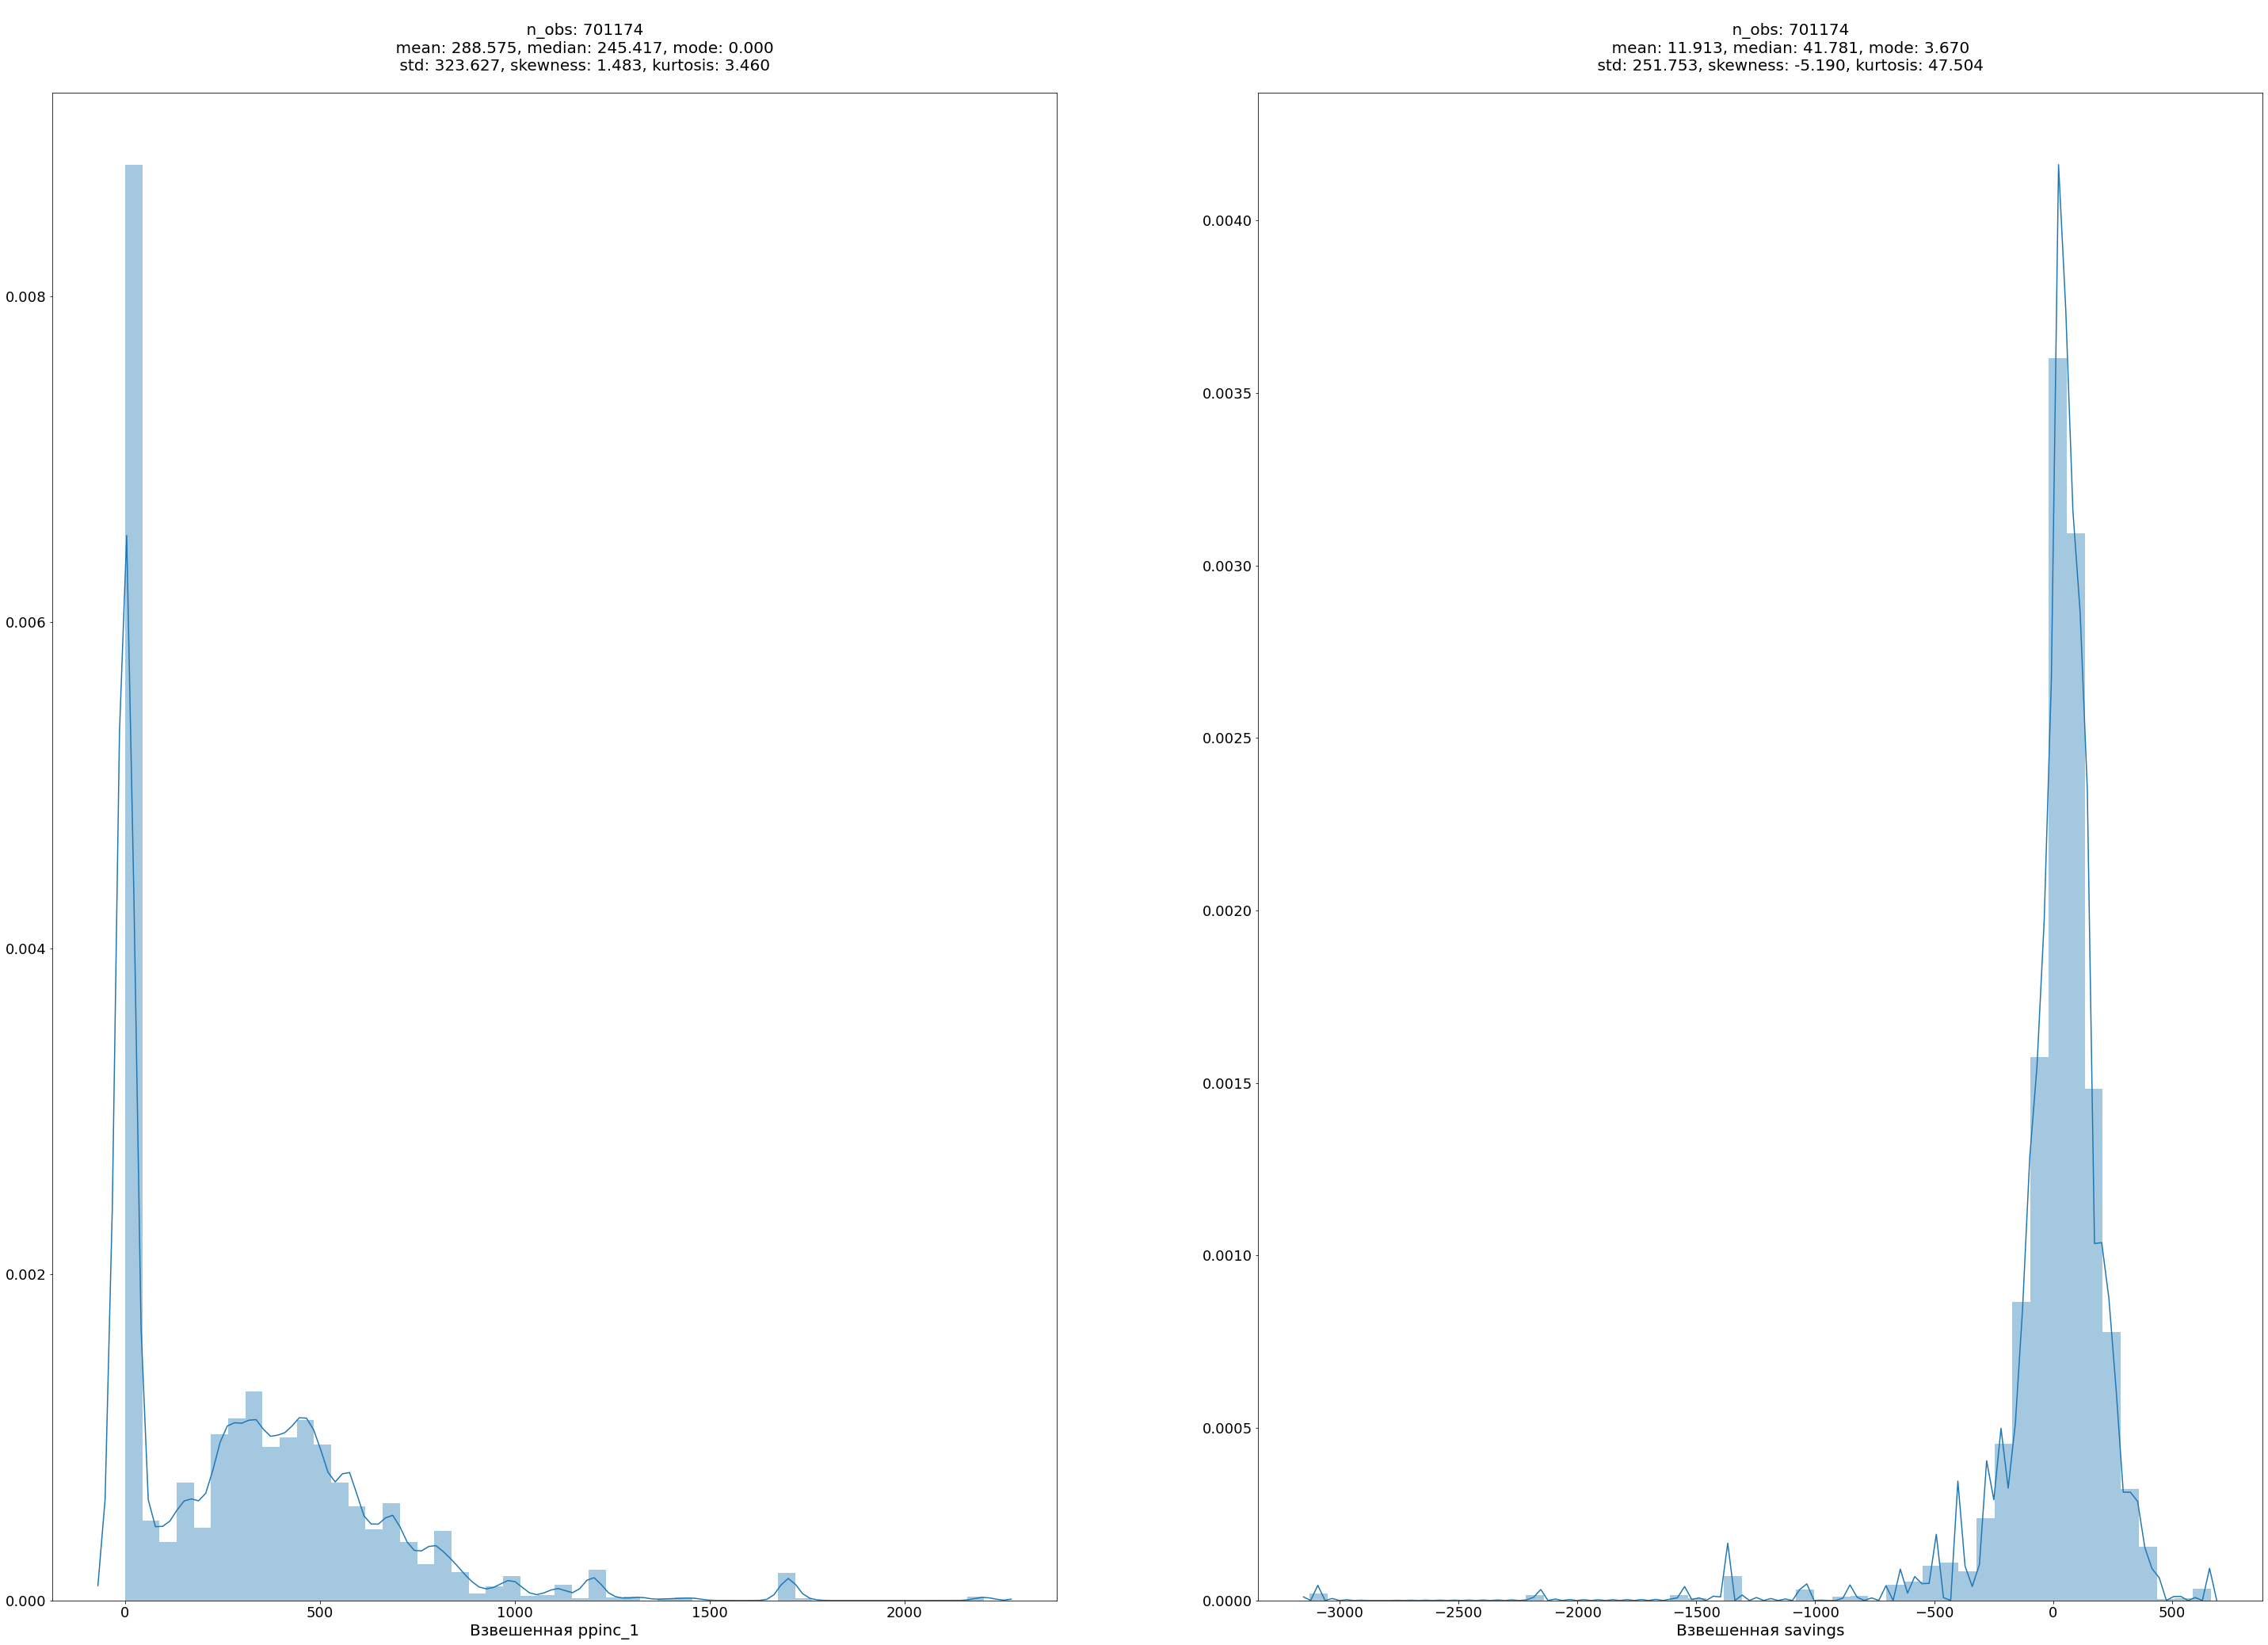

In [37]:
def get_stats(df_column : pd.Series):
    """
    Takes pandas Series and returns it's string representation
    """
    col_mean = df_column.mean()
    col_median = df_column.median()
    col_mode = df_column.mode()[0]
    col_std = df_column.std()
    col_skew = df_column.skew()
    col_kurt = df_column.kurt()
    return f"""
            n_obs: {len(df_column)}
            mean: {col_mean:.3f}, median: {col_median:.3f}, mode: {col_mode:.3f}
            std: {col_std:.3f}, skewness: {col_skew:.3f}, kurtosis: {col_kurt:.3f}
            """
            
fig, axes = plt.subplots(1, 2, figsize=(50, 35))

sns.distplot(weighted_df["ppinc_1"], ax=axes[0]).set_title(get_stats(weighted_df["ppinc_1"]), fontsize=20)
axes[0].set_xlabel("Взвешенная ppinc_1", fontsize=20)

sns.distplot(weighted_df["savings"], ax=axes[1]).set_title(get_stats(weighted_df["savings"]), fontsize=20)
axes[1].set_xlabel("Взвешенная savings", fontsize=20)

# 2. Исследование однородности данных домохозяйств методами проверки гипотез, дисперсионного анализа и таблиц сопряженности

Рассмотрев взвешенную выборку, среднее значения зарплат не равны 815.25 (уровень значимости теста p-value = 0). То есть можно отклонить нулевую гипотезу.
По взвешенной выборке среднее значение зарплаты = 465 рубля
Наше полученное значение не сходится с официальным!

In [38]:
print("\nWeighted df, t-test на равенство среднего 815.25 рублям:",stats.ttest_1samp(weighted_df_nonzero_salary["ppinc_1"],815.25))
print("ppinc_1 mean (weighted):", weighted_df_nonzero_salary["ppinc_1"].mean())


Weighted df, t-test на равенство среднего 815.25 рублям: Ttest_1sampResult(statistic=-784.0938921412557, pvalue=0.0)
ppinc_1 mean (weighted): 465.24533324448015


Таблица сопряженности между признаками sex и salary_categorical показывает, что у мужчин зарплата больше, чем у женщин.

In [41]:
df["age_categorical"] = df["age"].apply(lambda x : "18-24" if (x >= 18 and x <= 24)
                                                else "25-34" if (x >= 25 and x <= 34)
                                                else "35-44" if (x >= 35 and x <= 44)
                                                else "45-54" if (x >= 45 and x <= 54)
                                                else "55-64" if (x >= 55 and x <= 64)
                                                else pd.NA)
df["salary_categorical"] = df["ppinc_1"].apply(lambda x : pd.NA if (x == 0)
                                                      else "0-400" if (x > 0 and x < 400)
                                                      else "400-500" if (x >= 400 and x < 500)
                                                      else "500-700" if (x >= 500 and x < 700)
                                                      else "700-1000" if (x >= 700 and x < 1000)
                                                      else ">= 1000")
df
sex_salary_crosstab = pd.crosstab(df["sex"], df["salary_categorical"])
sex_salary_crosstab

salary_categorical,0-400,400-500,500-700,700-1000,>= 1000
sex,,,,,
Female,352,116,101,41,12
Male,229,92,134,81,29


Таблица сопряженности между признаками educat и sport показывает, что люди, которые получили высшее образование больше заботятся о своём здоровье 🏼💪🏻

In [42]:
education_sport_crosstab = pd.crosstab(df["educat"], df["sport"])
education_sport_crosstab

sport,No,"Yes, in establishment of education","Yes, in free time","Yes, on professional basis"
educat,,,,
Basic education,47,1,3,0
"Higher education, After Higher education",334,0,189,6
"Primary education,Dont Educat",21,0,1,0
Secondary education,317,6,53,2
Secondary specialized education,506,1,161,2
Vocational school,253,0,40,0


### Многомерная Т-статистика Хотеллинга 

Нулевая гипотеза: домохозяйства из двух произвольных регионов (Минск и Минская область) имеют одинаковые средние значений переменных cashinc, inkind, privlg p-value = 0, следовательно, мы отклоняем нулевую гипотезу

In [45]:
def t2_test_2samp(X, Y):
    nx, p1 = X.shape
    ny, p2 = Y.shape 
    if (p1 != p2):
        raise ValueError(f"X and Y must have same number of columns, but X has {p1} columns and Y has {p2} columns") 
    p = p1
    delta = np.mean(X, axis=0) - np.mean(Y, axis=0)
    Sx = np.cov(X, rowvar=False)
    Sy = np.cov(Y, rowvar=False)
    S_pooled = ((nx-1)*Sx + (ny-1)*Sy)/(nx+ny-2)
    t_squared = (nx*ny)/(nx+ny) * np.matmul(np.matmul(delta.transpose(), np.linalg.inv(S_pooled)), delta)
    t2_stat = t_squared * (nx+ny-p-1)/(p*(nx+ny-2))
    F = stats.f(p, nx+ny-p-1)
    p_value = 1 - F.cdf(t2_stat)
    return t2_stat, p_value
t2_stat, p = t2_test_2samp(df[df["region"] == "Minsk city"][["cashinc", "inkind", "privlg"]].dropna(), df[df["region"] == "Minsk oblast"][["cashinc", "inkind", "privlg"]].dropna())
print(f"Test statistic: {t2_stat}\np-value: {p}")

Test statistic: 53.46756829200893
p-value: 1.1102230246251565e-16


# 3. Корреляционный и регрессионный анализ данных домохозяйств

### Матрица корреляции Пирсона 

p_value >= 0.05 (т.е. корреляция равна нулю) для следующих пар переменных {inc_4, inkind}, {inc_4, privlg}, {inkind,privlg}, {inkind, exp_4}

Между остальными парами переменных имеется существенная корреляция. Самая большая корреляция между totalinc и cashinc - 0.99 (т.е. там наблюдается линейная зависимость)

In [50]:
COLS_FOR_ANALYSIS_t1 = ["inc_4", "cashinc", "inkind", "privlg", "totalinc", "exp_4"]
COLS_FOR_ANALYSIS_t2 = ["salary_categorical", "sex", "sport", "educat", "healthev", "smoker"]
pg.rcorr(df[COLS_FOR_ANALYSIS_t1], decimals=2, method="pearson", stars=False)

,inc_4,cashinc,inkind,privlg,totalinc,exp_4
inc_4,-,0.03,0.08,0.12,0.02,0.00
cashinc,-0.05,-,0.00,0.03,0.,0.00
inkind,-0.04,0.07,-,0.21,0.00,0.23
privlg,0.04,0.05,-0.03,-,0.00,0.00
totalinc,-0.05,0.99,0.18,0.09,-,0.00
exp_4,-0.24,0.52,0.03,0.06,0.52,-


### Матрица корреляции Пирсона после log-преобразования

Коэффицент корреляций измененились (т.к. логарифм - нелинейное преобразование, а корреляция Пирсона измеряет линейную зависимость между переменными), но эти изменения незначительны.
Признаки, которые слабо коррелировали между собой остались слабо кореллирующими, а там, где была сильная корреляция, она сохранилась

In [51]:
pg.rcorr(np.log(df[COLS_FOR_ANALYSIS_t1] + 1e-16), decimals=2, method="pearson", stars=False)

,inc_4,cashinc,inkind,privlg,totalinc,exp_4
inc_4,-,0.00,0.13,0.00,0.00,0.00
cashinc,-0.2,-,0.11,0.20,0.,0.00
inkind,-0.03,0.04,-,0.58,0.00,0.00
privlg,0.13,-0.03,0.01,-,0.88,0.94
totalinc,-0.21,0.99,0.08,0.0,-,0.00
exp_4,-0.16,0.26,0.08,0.0,0.27,-


### Частные коэффициенты корреляции

Как можно заметить из матрицы частных корреляций, totalinc, totalexp и ppinc_1 положительно коррелируют между собой. При этом интересно, что общие доходы и расходы (между собой почти линейно зависимы - коэффицент 0.93) не всегда зависят от уровня зарплаты (о чем свидетельствует корреляция около 0.5)

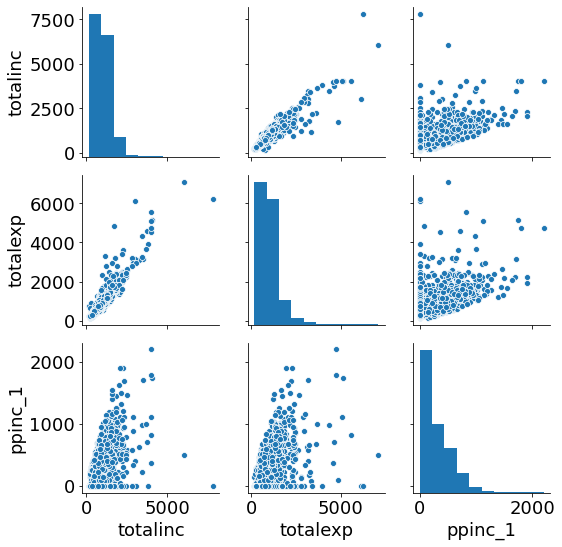

In [55]:
sns.pairplot(df[["totalinc", "totalexp", "ppinc_1"]])

Наблюдается положительная корреляция с признаками cashinc (0.53), totalexp (0.49) и exp_4 (0.43), а также отрицательная корреляция с inc_4 (-0.37, т.к. inc_4 - доход от пенсии). С признаками inkind и privlg существенной корреляции не обнаружено.

In [57]:
pg.rcorr(df[["inc_4", "cashinc", "inkind", "privlg", "exp_4", "totalexp"]], decimals=2, method="pearson", stars=False)

,inc_4,cashinc,inkind,privlg,exp_4,totalexp
inc_4,-,0.03,0.08,0.12,0.00,0.01
cashinc,-0.05,-,0.00,0.03,0.00,0.
inkind,-0.04,0.07,-,0.21,0.23,0.02
privlg,0.04,0.05,-0.03,-,0.00,0.02
exp_4,-0.24,0.52,0.03,0.06,-,0.00
totalexp,-0.06,0.94,0.05,0.05,0.52,-


### Ordinal Regression для healthev

Признаки sport и sport_bin в модели ведут себя одинаково. Скорректированный R^2 = 0.756

In [62]:
healthev_order = {"nan" : np.nan, "Bad" : 0, "Not very good, but not bad" : 1, "Good" : 2}
sport_order = {"nan" : np.nan, "No" : 0, "Yes, in establishment of education" : 1, "Yes, in free time" : 2, "Yes, on professional basis" : 3}
df["healthev_int"] = df["healthev"].map(healthev_order)
df["sport_int"] = df["sport"].map(sport_order)
df["sport_bin"] = (df["sport_int"] > 0).astype(int)
health_df = df[["healthev_int", "sport_int", "sport_bin", "bmi"]].dropna()
health_df

,healthev_int,sport_int,sport_bin,bmi
9460,2.0,0.0,0,26.196187
5545,0.0,0.0,0,24.801587
297,1.0,0.0,0,30.859607
6638,2.0,2.0,1,22.893074
10072,1.0,0.0,0,40.404040
...,...,...,...,...
1922,2.0,2.0,1,23.795360
2741,1.0,2.0,1,26.438071
10673,1.0,0.0,0,22.857143
2426,1.0,2.0,1,42.517007


In [63]:
mod = smf.ols("healthev_int ~ sport_int + bmi - 1", data=health_df, ).fit()
print(mod.summary())

                                 OLS Regression Results                                
Dep. Variable:           healthev_int   R-squared (uncentered):                   0.756
Model:                            OLS   Adj. R-squared (uncentered):              0.756
Method:                 Least Squares   F-statistic:                              3008.
Date:                Sun, 27 Dec 2020   Prob (F-statistic):                        0.00
Time:                        15:35:03   Log-Likelihood:                         -1892.5
No. Observations:                1943   AIC:                                      3789.
Df Residuals:                    1941   BIC:                                      3800.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [65]:
mod = smf.ols("healthev_int ~ sport_bin + bmi - 1", data=health_df, ).fit()
print(mod.summary())

                                 OLS Regression Results                                
Dep. Variable:           healthev_int   R-squared (uncentered):                   0.756
Model:                            OLS   Adj. R-squared (uncentered):              0.756
Method:                 Least Squares   F-statistic:                              3008.
Date:                Sun, 27 Dec 2020   Prob (F-statistic):                        0.00
Time:                        15:35:30   Log-Likelihood:                         -1892.5
No. Observations:                1943   AIC:                                      3789.
Df Residuals:                    1941   BIC:                                      3800.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------